# En este ejercicio vamos a predecir series temporales #

(Credits to :  https://towardsdatascience.com/time-series-analysis-in-python-an-introduction-70d5a5b1d52a)

Vamos a descargarnos las cotizaciones de dos empresas, Tesla y General Motors, y predecir su capitalización. <br>

<div class="alert alert-info" role="alert">
 Para ello vamos a usar :<br>
 - La librería de facebook **prophet**, para predecir series temporales. https://facebook.github.io/prophet/ <br>
 - El API de **Quandle**, para descargar cotizaciones bursatiles. https://www.quandl.com/ <br>
</div>

<br>

<div class="alert alert-danger" role="alert">
  En lo que se refiere a series temporales financieras, **resultados pasados no garantizan ingresos futuros**. <br>
  La información de este ejercicio no debe usarse para intentar hacerse rico.
<div>

 

## Nos descargamos el histórico de cotizaciones de Tesla y General Motors. ##

In [2]:


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import html5lib

from pathlib import Path
import pickle
import quandl


# Si el objeto ya lo tenemos, nos evitamos el descargarlo, y lo cargamos de disco
my_file = Path("datasets/tesla.pickle")
if my_file.exists():
    with open(r"datasets/tesla.pickle", "rb") as input_file:
        tesla = pickle.load(input_file)
else:
    # Retrieve TSLA data from Quandl
    tesla = quandl.get('WIKI/TSLA')

my_file = Path("datasets/gm.pickle")
if my_file.exists():
    with open(r"datasets/gm.pickle", "rb") as input_file:
        gm = pickle.load(input_file)
else:
    # Retrieve the GM data from Quandl
    gm = quandl.get('WIKI/GM')
            

        


tesla.head(5)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0
2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0
2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0
2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0
2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0


In [3]:
tesla.index.year

Int64Index([2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010,
            ...
            2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018],
           dtype='int64', name='Date', length=1949)

## Gráfica de la evolución de la cotización, para ambas empresas. ##

In [4]:
import matplotlib.pyplot as plt

# The adjusted close accounts for stock splits, so that is what we should graph
plt.plot(gm.index, gm['Adj. Close'])
plt.title('GM Stock Price')
plt.ylabel('Price ($)');
plt.show()
plt.plot(tesla.index, tesla['Adj. Close'], 'r')
plt.title('Tesla Stock Price')
plt.ylabel('Price ($)');
plt.show();

## Calculamos, el valor de capitalización de ambas empresa (valor de mercado) ##

Valor de capitalización es el precio de la acción, por el número de acciones.
Market cap= share price * number of shares).



In [5]:
# Yearly average number of shares outstanding for Tesla and GM
tesla_shares = {2018: 168e6, 2017: 162e6, 2016: 144e6, 2015: 128e6, 2014: 125e6, 2013: 119e6, 2012: 107e6, 2011: 100e6, 2010: 51e6}
gm_shares = {2018: 1.42e9, 2017: 1.50e9, 2016: 1.54e9, 2015: 1.59e9, 2014: 1.61e9, 2013: 1.39e9, 2012: 1.57e9, 2011: 1.54e9, 2010:1.50e9}
# Create a year column 
tesla['Year'] = tesla.index.year
# Take Dates from index and move to Date column 
tesla.reset_index(level=0, inplace = True)
tesla['cap'] = 0
# Calculate market cap for all years
for i, year in enumerate(tesla['Year']):
    # Retrieve the shares for the year
    shares = tesla_shares.get(year)
    # Update the cap column to shares times the price
    tesla.ix[i, 'cap'] = shares * tesla.ix[i, 'Adj. Close']
    

In [6]:
# Create a year column 
gm['Year'] = gm.index.year
# Take Dates from index and move to Date column 
gm.reset_index(level=0, inplace = True)
gm['cap'] = 0
# Calculate market cap for all years
for i, year in enumerate(gm['Year']):
    # Retrieve the shares for the year
    shares = gm_shares.get(year)
    # Update the cap column to shares times the price
    gm.ix[i, 'cap'] = shares * gm.ix[i, 'Adj. Close']
    


In [7]:
# Merge the two datasets and rename the columns
cars = gm.merge(tesla, how='inner', on='Date')

cars.rename(columns={'cap_x': 'gm_cap', 'cap_y': 'tesla_cap'}, inplace=True)
# Select only the relevant columns
cars = cars.ix[:, ['Date', 'gm_cap', 'tesla_cap']]
# Divide to get market cap in billions of dollars
cars['gm_cap'] = cars['gm_cap'] / 1e9
cars['tesla_cap'] = cars['tesla_cap'] / 1e9
cars.head()

,Date,gm_cap,tesla_cap
0,2010-11-18,43.941453,1.52439
1,2010-11-19,44.031417,1.58049
2,2010-11-22,43.800079,1.70340
3,2010-11-23,42.733352,1.76307
4,2010-11-24,43.028951,1.80897


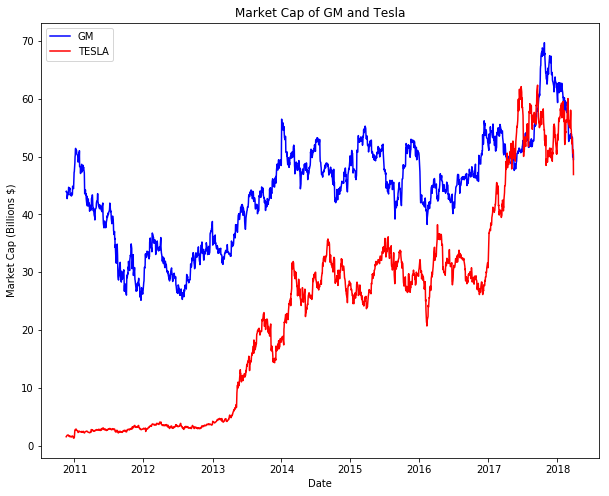

In [8]:
plt.figure(figsize=(10, 8))
plt.plot(cars['Date'], cars['gm_cap'], 'blue', label = 'GM')
plt.plot(cars['Date'], cars['tesla_cap'], 'red', label = 'TESLA')
plt.xlabel('Date')
plt.ylabel('Market Cap (Billions $)') ; plt.title('Market Cap of GM and Tesla')
plt.legend();

In [9]:
import numpy as np
# Find the first and last time Tesla was valued higher than GM
first_date = cars.ix[np.min(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
last_date = cars.ix[np.max(list(np.where(cars['tesla_cap'] > cars['gm_cap'])[0])), 'Date']
print("Tesla was valued higher than GM from {} to {}.".format(first_date.date(), last_date.date()))

Tesla was valued higher than GM from 2017-04-10 to 2018-03-23.


## Preprocesamos la información para que adopta el formato que espera fbprophet ##

 - Columna "ds", con la fecha.
 - Columna "y", por cada valor a predecir : Capitalización de cada empresa.


In [10]:
# Prophet requires columns ds (Date) and y (value)
gm = gm.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
gm['y'] = gm['y'] / 1e9
# Make the prophet model and fit on the data
gm[['ds','y']].head()

,ds,y
0,2010-11-18,43.941453
1,2010-11-19,44.031417
2,2010-11-22,43.800079
3,2010-11-23,42.733352
4,2010-11-24,43.028951


## Generamos el modelo para hacer la predicción ## 

<div class="alert alert-info" role="alert">
 Fbprophet nos da un modelo, que una vez entrenado nos predecirá los valores futuros de la serie temporal, incluyendo tendencias, valores  máximos/minimos, y otrtos valores
<div>

 

In [11]:
import fbprophet

gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
gm_prophet.fit(gm)

# Make a future dataframe for 2 years
gm_forecast = gm_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
gm_forecast = gm_prophet.predict(gm_forecast)
gm_forecast


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-11-18,42.630364,42.630364,42.630364,41.623258,48.475774,2.638258,2.638258,2.638258,2.638258,2.638258,2.638258,0.238137,0.238137,0.238137,2.400121,2.400121,2.400121,45.268622
1,2010-11-19,42.658981,42.658981,42.658981,41.972491,48.506187,2.635332,2.635332,2.635332,2.635332,2.635332,2.635332,0.185635,0.185635,0.185635,2.449697,2.449697,2.449697,45.294312
2,2010-11-22,42.744831,42.744831,42.744831,42.403719,48.955599,2.826995,2.826995,2.826995,2.826995,2.826995,2.826995,0.216216,0.216216,0.216216,2.610779,2.610779,2.610779,45.571826
3,2010-11-23,42.773448,42.773448,42.773448,42.559894,48.857121,2.824951,2.824951,2.824951,2.824951,2.824951,2.824951,0.161423,0.161423,0.161423,2.663528,2.663528,2.663528,45.598399
4,2010-11-24,42.802065,42.802065,42.802065,42.413953,48.897318,2.951578,2.951578,2.951578,2.951578,2.951578,2.951578,0.238382,0.238382,0.238382,2.713196,2.713196,2.713196,45.753643
5,2010-11-26,42.859298,42.859298,42.859298,42.608766,49.239674,2.982967,2.982967,2.982967,2.982967,2.982967,2.982967,0.185635,0.185635,0.185635,2.797332,2.797332,2.797332,45.842265
6,2010-11-29,42.945149,42.945149,42.945149,42.800076,49.330080,3.082808,3.082808,3.082808,3.082808,3.082808,3.082808,0.216216,0.216216,0.216216,2.866592,2.866592,2.866592,46.027956
7,2010-11-30,42.973766,42.973766,42.973766,42.786100,49.320869,3.032209,3.032209,3.032209,3.032209,3.032209,3.032209,0.161423,0.161423,0.161423,2.870786,2.870786,2.870786,46.005975
8,2010-12-01,43.002382,43.002382,43.002382,42.918537,49.219724,3.103078,3.103078,3.103078,3.103078,3.103078,3.103078,0.238382,0.238382,0.238382,2.864696,2.864696,2.864696,46.105461
9,2010-12-02,43.030999,43.030999,43.030999,42.866787,49.316461,3.086374,3.086374,3.086374,3.086374,3.086374,3.086374,0.238137,0.238137,0.238137,2.848237,2.848237,2.848237,46.117374


In [12]:
# Se puede hacer mas limpio, solo con las dos columnas
df = pd.DataFrame()
df["ds"] = gm["ds"]
df["y"] = gm["y"]
df.head()

,ds,y
0,2010-11-18,43.941453
1,2010-11-19,44.031417
2,2010-11-22,43.800079
3,2010-11-23,42.733352
4,2010-11-24,43.028951


In [13]:
# Con solo dos columnas, sale esta predicción.
import fbprophet

# Generamos un modelo, y lo entrenamos
df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

# Make a future dataframe for 2 years
df_forecast = df_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-11-18,42.630364,42.630364,42.630364,41.919883,48.533676,2.638258,2.638258,2.638258,2.638258,2.638258,2.638258,0.238137,0.238137,0.238137,2.400121,2.400121,2.400121,45.268622
1,2010-11-19,42.658981,42.658981,42.658981,42.030129,48.454684,2.635332,2.635332,2.635332,2.635332,2.635332,2.635332,0.185635,0.185635,0.185635,2.449697,2.449697,2.449697,45.294312
2,2010-11-22,42.744831,42.744831,42.744831,42.094168,48.918025,2.826995,2.826995,2.826995,2.826995,2.826995,2.826995,0.216216,0.216216,0.216216,2.610779,2.610779,2.610779,45.571826
3,2010-11-23,42.773448,42.773448,42.773448,42.447300,48.925434,2.824951,2.824951,2.824951,2.824951,2.824951,2.824951,0.161423,0.161423,0.161423,2.663528,2.663528,2.663528,45.598399
4,2010-11-24,42.802065,42.802065,42.802065,42.622275,48.829787,2.951578,2.951578,2.951578,2.951578,2.951578,2.951578,0.238382,0.238382,0.238382,2.713196,2.713196,2.713196,45.753643
5,2010-11-26,42.859298,42.859298,42.859298,42.784667,48.913374,2.982967,2.982967,2.982967,2.982967,2.982967,2.982967,0.185635,0.185635,0.185635,2.797332,2.797332,2.797332,45.842265
6,2010-11-29,42.945149,42.945149,42.945149,42.633814,49.349544,3.082808,3.082808,3.082808,3.082808,3.082808,3.082808,0.216216,0.216216,0.216216,2.866592,2.866592,2.866592,46.027956
7,2010-11-30,42.973766,42.973766,42.973766,42.509933,49.047920,3.032209,3.032209,3.032209,3.032209,3.032209,3.032209,0.161423,0.161423,0.161423,2.870786,2.870786,2.870786,46.005975
8,2010-12-01,43.002382,43.002382,43.002382,42.781873,49.474739,3.103078,3.103078,3.103078,3.103078,3.103078,3.103078,0.238382,0.238382,0.238382,2.864696,2.864696,2.864696,46.105461
9,2010-12-02,43.030999,43.030999,43.030999,42.519741,49.241639,3.086374,3.086374,3.086374,3.086374,3.086374,3.086374,0.238137,0.238137,0.238137,2.848237,2.848237,2.848237,46.117374


## Visualizamos los resultados de la predicción ##

El pronóstico será menos preciso, conforme aumenta el tiempo.


Text(0.5,1,'Market Cap of GM')

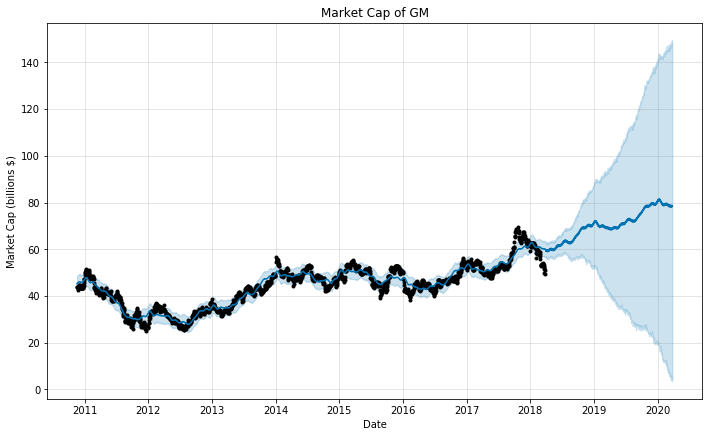

In [14]:
gm_prophet.plot(gm_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of GM')

In [15]:
# Same, with tesla
import fbprophet
# Prophet requires columns ds (Date) and y (value)
tesla = tesla.rename(columns={'Date': 'ds', 'cap': 'y'})
# Put market cap in billions
tesla['y'] = tesla['y'] / 1e9
# Make the prophet model and fit on the data
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
tesla_prophet.fit(tesla)
# Make a future dataframe for 2 years
tesla_forecast = tesla_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
tesla_forecast = tesla_prophet.predict(tesla_forecast)
tesla_forecast

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2010-06-29,-2.235436,-2.235436,-2.235436,-1.893988,4.309210,3.417176,3.417176,3.417176,3.417176,3.417176,3.417176,-0.693401,-0.693401,-0.693401,4.110577,4.110577,4.110577,1.181740
1,2010-06-30,-2.187830,-2.187830,-2.187830,-1.832733,4.429862,3.346774,3.346774,3.346774,3.346774,3.346774,3.346774,-0.663796,-0.663796,-0.663796,4.010570,4.010570,4.010570,1.158944
2,2010-07-01,-2.140223,-2.140223,-2.140223,-2.269963,4.022993,3.179197,3.179197,3.179197,3.179197,3.179197,3.179197,-0.725906,-0.725906,-0.725906,3.905103,3.905103,3.905103,1.038974
3,2010-07-02,-2.092617,-2.092617,-2.092617,-1.994180,4.170293,3.047022,3.047022,3.047022,3.047022,3.047022,3.047022,-0.748599,-0.748599,-0.748599,3.795621,3.795621,3.795621,0.954406
4,2010-07-06,-1.902190,-1.902190,-1.902190,-2.447208,3.803768,2.654316,2.654316,2.654316,2.654316,2.654316,2.654316,-0.693401,-0.693401,-0.693401,3.347716,3.347716,3.347716,0.752126
5,2010-07-07,-1.854583,-1.854583,-1.854583,-2.291968,3.951058,2.576895,2.576895,2.576895,2.576895,2.576895,2.576895,-0.663796,-0.663796,-0.663796,3.240691,3.240691,3.240691,0.722311
6,2010-07-08,-1.806977,-1.806977,-1.806977,-2.575486,3.891140,2.412515,2.412515,2.412515,2.412515,2.412515,2.412515,-0.725906,-0.725906,-0.725906,3.138421,3.138421,3.138421,0.605538
7,2010-07-09,-1.759370,-1.759370,-1.759370,-2.655588,3.818316,2.293518,2.293518,2.293518,2.293518,2.293518,2.293518,-0.748599,-0.748599,-0.748599,3.042117,3.042117,3.042117,0.534147
8,2010-07-12,-1.616550,-1.616550,-1.616550,-2.600472,3.549187,2.117002,2.117002,2.117002,2.117002,2.117002,2.117002,-0.681866,-0.681866,-0.681866,2.798868,2.798868,2.798868,0.500452
9,2010-07-13,-1.568944,-1.568944,-1.568944,-2.825583,3.759936,2.042038,2.042038,2.042038,2.042038,2.042038,2.042038,-0.693401,-0.693401,-0.693401,2.735438,2.735438,2.735438,0.473094


Text(0.5,1,'Market Cap of Tesla')

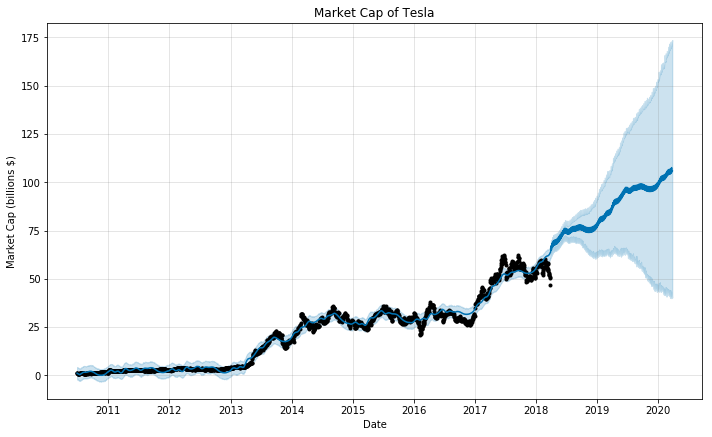

In [16]:
tesla_prophet.plot(tesla_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Market Cap of Tesla')

## Tambien se pueden detectar los cambios de tendencia alcista/bajista##

In [17]:
gm_prophet.changepoints[:10]


59    2011-02-14
118   2011-05-10
177   2011-08-03
237   2011-10-27
296   2012-01-24
355   2012-04-18
414   2012-07-12
473   2012-10-04
532   2013-01-02
592   2013-04-01
Name: ds, dtype: datetime64[ns]

In [18]:
gm_names = ['gm_%s' % column for column in gm_forecast.columns]
tesla_names = ['tesla_%s' % column for column in tesla_forecast.columns]
# Dataframes to merge
merge_gm_forecast = gm_forecast.copy()
merge_tesla_forecast = tesla_forecast.copy()
# Rename the columns
merge_gm_forecast.columns = gm_names
merge_tesla_forecast.columns = tesla_names
# Merge the two datasets
forecast = pd.merge(merge_gm_forecast, merge_tesla_forecast, how = 'inner', left_on = 'gm_ds', right_on = 'tesla_ds')
# Rename date column
forecast = forecast.rename(columns={'gm_ds': 'Date'}).drop('tesla_ds', axis=1)

In [19]:
forecast

,Date,gm_trend,gm_trend_lower,gm_trend_upper,gm_yhat_lower,gm_yhat_upper,gm_seasonal,gm_seasonal_lower,gm_seasonal_upper,gm_seasonalities,...,tesla_seasonalities,tesla_seasonalities_lower,tesla_seasonalities_upper,tesla_weekly,tesla_weekly_lower,tesla_weekly_upper,tesla_yearly,tesla_yearly_lower,tesla_yearly_upper,tesla_yhat
0,2010-11-18,42.630364,42.630364,42.630364,41.623258,48.475774,2.638258,2.638258,2.638258,2.638258,...,-4.462846,-4.462846,-4.462846,-0.725906,-0.725906,-0.725906,-3.736940,-3.736940,-3.736940,0.061858
1,2010-11-19,42.658981,42.658981,42.658981,41.972491,48.506187,2.635332,2.635332,2.635332,2.635332,...,-4.534872,-4.534872,-4.534872,-0.748599,-0.748599,-0.748599,-3.786273,-3.786273,-3.786273,0.037439
2,2010-11-22,42.744831,42.744831,42.744831,42.403719,48.955599,2.826995,2.826995,2.826995,2.826995,...,-4.606700,-4.606700,-4.606700,-0.681866,-0.681866,-0.681866,-3.924833,-3.924833,-3.924833,0.108431
3,2010-11-23,42.773448,42.773448,42.773448,42.559894,48.857121,2.824951,2.824951,2.824951,2.824951,...,-4.661003,-4.661003,-4.661003,-0.693401,-0.693401,-0.693401,-3.967602,-3.967602,-3.967602,0.101735
4,2010-11-24,42.802065,42.802065,42.802065,42.413953,48.897318,2.951578,2.951578,2.951578,2.951578,...,-4.672329,-4.672329,-4.672329,-0.663796,-0.663796,-0.663796,-4.008533,-4.008533,-4.008533,0.138015
5,2010-11-26,42.859298,42.859298,42.859298,42.608766,49.239674,2.982967,2.982967,2.982967,2.982967,...,-4.833222,-4.833222,-4.833222,-0.748599,-0.748599,-0.748599,-4.084623,-4.084623,-4.084623,0.072335
6,2010-11-29,42.945149,42.945149,42.945149,42.800076,49.330080,3.082808,3.082808,3.082808,3.082808,...,-4.865556,-4.865556,-4.865556,-0.681866,-0.681866,-0.681866,-4.183689,-4.183689,-4.183689,0.182822
7,2010-11-30,42.973766,42.973766,42.973766,42.786100,49.320869,3.032209,3.032209,3.032209,3.032209,...,-4.906014,-4.906014,-4.906014,-0.693401,-0.693401,-0.693401,-4.212614,-4.212614,-4.212614,0.189970
8,2010-12-01,43.002382,43.002382,43.002382,42.918537,49.219724,3.103078,3.103078,3.103078,3.103078,...,-4.903290,-4.903290,-4.903290,-0.663796,-0.663796,-0.663796,-4.239494,-4.239494,-4.239494,0.240300
9,2010-12-02,43.030999,43.030999,43.030999,42.866787,49.316461,3.086374,3.086374,3.086374,3.086374,...,-4.990253,-4.990253,-4.990253,-0.725906,-0.725906,-0.725906,-4.264348,-4.264348,-4.264348,0.200944


## Predecimos cuando ambos valores de capitalización bursatil se cruzarán##

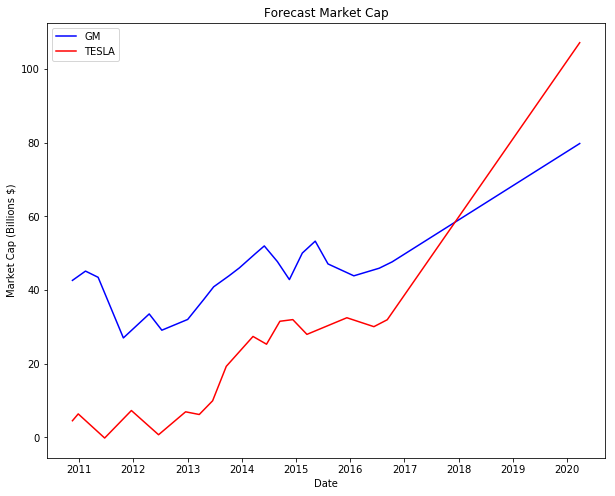

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date'], forecast['gm_trend'], 'blue', label = 'GM')
plt.plot(forecast['Date'], forecast['tesla_trend'], 'red', label = 'TESLA')
plt.xlabel('Date'); plt.ylabel('Market Cap (Billions $)'); plt.title('Forecast Market Cap')
plt.legend();

## Conclusión ##

Prophet es una librería para la predicción de series temporales, que permite predicciones robustas.



In [ ]:
# Cogemos los datos de telefonica
tf = quandl.get('EURONEXT/TFA-Telefonica-TFA')
tf


In [39]:
# Cogemos los datos de telefonica
tf = quandl.get('EURONEXT/TFA-Telefonica-TFA')
tf
# Generar las columnas "ds", a partir del indice, 
# y la columna "y", a partir del valor Last. 

# Generar el modelo, y hacer la predicción

# Mostrar el gráfico
    

In [30]:
df["ds"] = df.index
df["y"] = df["Last"]
for column in ["Open","High","Low","Last","Volume","Turnover"] : 
    del df[column]
    


,ds,y
Date,,
2014-02-14,2014-02-14,11.330
2014-02-17,2014-02-17,11.300
2014-02-18,2014-02-18,11.250
2014-02-19,2014-02-19,11.250
2014-02-20,2014-02-20,11.270
2014-02-21,2014-02-21,11.280
2014-02-24,2014-02-24,11.450
2014-02-25,2014-02-25,11.300
2014-02-26,2014-02-26,11.430


In [40]:
# Con solo dos columnas, sale esta predicción.

import fbprophet
# Generamos un modelo, y lo entrenamos
tf_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
tf_prophet.fit(tf)

# Make a future dataframe for 2 years
tf_forecast = tf_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
tf_forecast = tf_prophet.predict(df_forecast)
tf_forecast

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2014-02-14,10.993328,10.993328,10.993328,10.196478,11.169856,-0.309706,-0.309706,-0.309706,-0.309706,-0.309706,-0.309706,-0.025413,-0.025413,-0.025413,-0.284292,-0.284292,-0.284292,10.683622
1,2014-02-17,11.022365,11.022365,11.022365,10.316214,11.256588,-0.235540,-0.235540,-0.235540,-0.235540,-0.235540,-0.235540,-0.007268,-0.007268,-0.007268,-0.228273,-0.228273,-0.228273,10.786824
2,2014-02-18,11.032044,11.032044,11.032044,10.340886,11.255378,-0.238765,-0.238765,-0.238765,-0.238765,-0.238765,-0.238765,-0.033891,-0.033891,-0.033891,-0.204874,-0.204874,-0.204874,10.793279
3,2014-02-19,11.041723,11.041723,11.041723,10.368317,11.268927,-0.201057,-0.201057,-0.201057,-0.201057,-0.201057,-0.201057,-0.021630,-0.021630,-0.021630,-0.179427,-0.179427,-0.179427,10.840665
4,2014-02-20,11.051401,11.051401,11.051401,10.429284,11.355070,-0.165540,-0.165540,-0.165540,-0.165540,-0.165540,-0.165540,-0.013354,-0.013354,-0.013354,-0.152187,-0.152187,-0.152187,10.885861
5,2014-02-21,11.061080,11.061080,11.061080,10.429056,11.371217,-0.148856,-0.148856,-0.148856,-0.148856,-0.148856,-0.148856,-0.025413,-0.025413,-0.025413,-0.123443,-0.123443,-0.123443,10.912224
6,2014-02-24,11.090117,11.090117,11.090117,10.609918,11.518819,-0.038774,-0.038774,-0.038774,-0.038774,-0.038774,-0.038774,-0.007268,-0.007268,-0.007268,-0.031507,-0.031507,-0.031507,11.051343
7,2014-02-25,11.099796,11.099796,11.099796,10.595705,11.518013,-0.034045,-0.034045,-0.034045,-0.034045,-0.034045,-0.034045,-0.033891,-0.033891,-0.033891,-0.000154,-0.000154,-0.000154,11.065751
8,2014-02-26,11.109475,11.109475,11.109475,10.617714,11.594352,0.009306,0.009306,0.009306,0.009306,0.009306,0.009306,-0.021630,-0.021630,-0.021630,0.030936,0.030936,0.030936,11.118781
9,2014-02-27,11.119154,11.119154,11.119154,10.708155,11.638063,0.048044,0.048044,0.048044,0.048044,0.048044,0.048044,-0.013354,-0.013354,-0.013354,0.061398,0.061398,0.061398,11.167198


Text(0.5,1,'Valor de la accion of Tf')

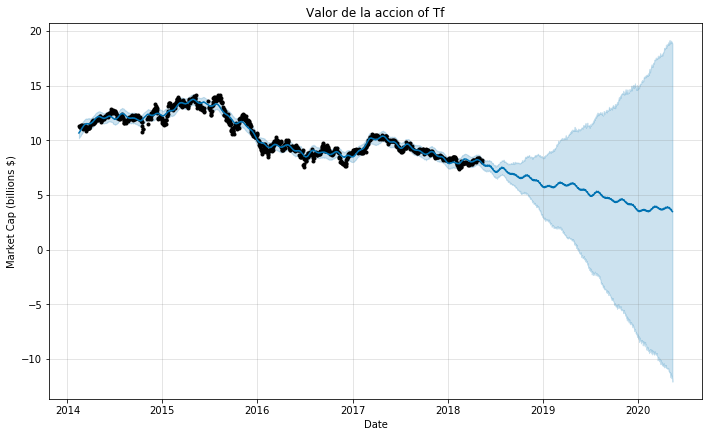

In [41]:
tf_prophet.plot(tf_forecast, xlabel = 'Date', ylabel = 'Market Cap (billions $)')
plt.title('Valor de la accion of Tf')